### Preprocessing Data

In [25]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
from itertools import islice

filename_infrastructure = 'data_unwrangled/Centerline.csv'
filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'

In [2]:
infrastructure = pd.read_csv(filename_infrastructure)
infrastructure = gpd.GeoDataFrame(infrastructure)
infrastructure['the_geom'] = infrastructure['the_geom'].apply(shapely.wkt.loads)
infrastructure.set_geometry('the_geom', inplace=True)

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_29539/3234150003.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  infrastructure = pd.read_csv(filename_infrastructure)


In [3]:
# Hand chosen lower manhattan polygon because of high citibike density
#points_lat = [40.72702, 40.73375, 40.73336, 40.71464, 40.71505]
#points_long = [-73.97238, -73.98580, -73.99969, -74.01390, -73.97978]

points_lat = [40.6959, 40.7552, 40.7749, 40.7577, 40.7400, 40.7097, 40.7037]
points_long = [-74.0222, -74.0150, -73.9992, -73.9576, -73.9701, -73.9722, -73.9994]

#points_lat = [40.73, 40.70, 40.71, 40.73]
#points_long = [-74.02, -74.02, -73.98, -73.98]

# Create a polygon from the points 
filter = shapely.geometry.Polygon(zip(points_long, points_lat))
filter = gpd.GeoDataFrame(geometry = [filter])

<AxesSubplot:>

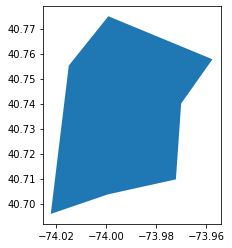

In [4]:
filter.plot()

In [5]:
infrastructure = infrastructure.sjoin(filter) # restrict streets to filter
if 'index_right' in infrastructure.columns:
    infrastructure.drop(columns=['index_right'], inplace=True)

<AxesSubplot:>

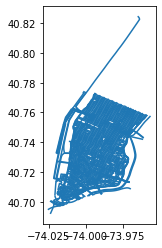

In [6]:
infrastructure.plot()

In [7]:
def get_neighbors(geometry, id):
    neighbors = infrastructure['PHYSICALID'].loc[infrastructure['the_geom'].intersects(geometry)].tolist()
    neighbors.remove(id)
    return neighbors

# Build column with adjacent links
# WARNING: Can only do on subset of data, otherwise it will take forever
infrastructure['neighbors'] = infrastructure.apply(lambda x: get_neighbors(x.the_geom, x.PHYSICALID), axis=1)

In [8]:
collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE'])

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_29539/1389750111.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE'])


In [9]:
mask = collisions['BOROUGH'].str.contains('bike') # placeholder
for i in [1,2,3,4,5]:
    mask = mask | collisions[f'VEHICLE TYPE CODE {i}'].str.contains('bike', case=False)

# Restrict to collisions involving bikes
collisions = collisions.loc[mask]

In [10]:
collisions = gpd.GeoDataFrame(collisions, geometry=gpd.points_from_xy(collisions.LONGITUDE, collisions.LATITUDE))

In [11]:
collisions.sjoin(filter)
if 'index_right' in collisions.columns:
    collisions.drop(columns=['index_right'], inplace=True)

In [12]:
collisions = collisions.sjoin_nearest(infrastructure, max_distance=0.0001)

In [13]:
collisions['CRASH DATE'] = pd.to_datetime(collisions['CRASH DATE'])
collisions.groupby([collisions['CRASH DATE'].dt.year]).count()
## So let's start in 2016!

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng,neighbors
CRASH DATE,,,,,,,,,,,,,,,,,,,,,
2012,1,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,1,1,0,1,1
2013,1,1,1,1,1,1,1,0,0,1,...,1,0,1,0,0,1,1,0,1,1
2014,2,2,2,2,2,2,2,1,1,1,...,1,0,2,0,0,2,2,0,2,2
2015,1,1,1,1,1,1,1,1,1,0,...,1,0,1,0,0,1,1,0,1,1
2016,1013,1013,843,843,1013,1013,1013,719,590,294,...,455,68,894,16,4,1013,1013,467,1013,1013
2017,1192,1192,960,960,1192,1192,1192,816,599,376,...,511,63,1063,9,1,1192,1192,585,1192,1192
2018,1148,1148,976,976,1148,1148,1148,819,656,329,...,547,51,1039,13,0,1148,1148,517,1148,1148
2019,1166,1166,984,984,1166,1166,1166,795,622,371,...,523,64,1041,9,1,1166,1166,555,1166,1166
2020,751,751,633,633,751,751,751,521,413,230,...,355,24,693,5,3,751,751,343,751,751


In [14]:

start_date = pd.Timestamp('2016-01-01')
collisions = collisions.loc[collisions['CRASH DATE'] > start_date]

In [15]:
year = '2016'
month = '01'
filename_citibike = f'data_unwrangled/citibike/{year}{month}-citibike-tripdata.csv'
citibike_yearmonth = pd.read_csv(filename_citibike)

In [16]:
citibike_yearmonth = gpd.GeoDataFrame(citibike_yearmonth)
citibike_yearmonth['start_geom'] = gpd.points_from_xy(citibike_yearmonth['start station longitude'], citibike_yearmonth['start station latitude'])
citibike_yearmonth['end_geom'] = gpd.points_from_xy(citibike_yearmonth['end station longitude'], citibike_yearmonth['end station latitude'])

In [17]:
for geom in ['start_geom', 'end_geom']:
    citibike_yearmonth.set_geometry(geom, inplace=True)
    citibike_yearmonth = citibike_yearmonth.sjoin(filter)
    if 'index_right' in citibike_yearmonth.columns:
        citibike_yearmonth.drop(columns=['index_right'], inplace=True)


<AxesSubplot:>

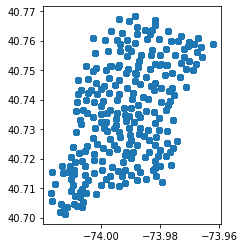

In [18]:
citibike_yearmonth.plot()
#len(citibike_yearmonth['start station id'].unique())

In [19]:
citibike_yearmonth['starttime'] = pd.to_datetime(citibike_yearmonth['starttime'])
citibike_yearmonth['starttime_rounded'] = citibike_yearmonth['starttime'].dt.floor('d')

In [20]:
len(citibike_yearmonth['end station id'].unique())

252

In [21]:
graph = nx.from_pandas_edgelist(infrastructure.explode('neighbors'), source='PHYSICALID', target='neighbors')

In [22]:
length = len(nx.shortest_path(graph, 29, 226))

In [28]:
k = 10
for path in list(islice(nx.shortest_simple_paths(graph, 29, 226), k)):
    print(path)
    print(len(path))

[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[29, 79163, 131907, 131905, 131906, 131898, 131895, 131896, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131996, 132002, 131998, 308, 132032, 1319, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 853, 228, 132031, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 176275, 132031, 227, 226]
24
[29, 173026, 131907, 131905, 131906, 131898, 131895, 131896, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[2